In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/My Drive/Colab Notebooks/TGMTNC

/content/drive/My Drive/Colab Notebooks/TGMTNC


In [3]:
!pip install torch==1.4
!pip install torchvision==0.5.0

In [4]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-epnwb6zv
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-epnwb6zv
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266976 sha256=9ef3ee985bec89821a25399f0de90adfa7578de0e6dbd30b27f9f1c7429bb96f
  Stored in directory: /tmp/pip-ephem-wheel-cache-tfu96px9/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0


In [5]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
# git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

error: Your local changes to the following files would be overwritten by checkout:
	.circleci/regenerate.py
	.circleci/unittest/linux/scripts/install.sh
	.circleci/unittest/linux/scripts/post_process.sh
	.circleci/unittest/linux/scripts/run_test.sh
	.circleci/unittest/linux/scripts/setup_env.sh
	packaging/build_conda.sh
	packaging/build_wheel.sh
	packaging/conda/build_vision.sh
	packaging/conda/switch_cuda_version.sh
	travis-scripts/run-clang-format/run-clang-format.py
Please commit your changes or stash them before you switch branches.
Aborting


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import time
import shutil
import torch.nn as nn
from skimage import io
import torchvision
import cv2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from albumentations.pytorch import ToTensor
from torchvision import utils
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize,Flip,Compose, GaussNoise)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:
train_dir = 'data-wheat/train'
valid_dir = 'data-wheat/val'
test_dir = 'data-wheat/test0'
bounding_box = 'train.csv'

In [8]:
df = pd.read_csv(bounding_box)
df.head()

image_id  width  height                         bbox   source
0  b6ab77fd7   1024    1024   [834.0, 222.0, 56.0, 36.0]  usask_1
1  b6ab77fd7   1024    1024  [226.0, 548.0, 130.0, 58.0]  usask_1
2  b6ab77fd7   1024    1024  [377.0, 504.0, 74.0, 160.0]  usask_1
3  b6ab77fd7   1024    1024  [834.0, 95.0, 109.0, 107.0]  usask_1
4  b6ab77fd7   1024    1024  [26.0, 144.0, 124.0, 117.0]  usask_1

In [9]:
# this function will take the dataframe and vertically stack the image ids 
# with no bounding boxes
def process_bbox(df):
    df['bbox'] = df['bbox'].apply(lambda x: eval(x))
    df['x'] = df['bbox'].apply(lambda x: x[0])
    df['y'] = df['bbox'].apply(lambda x: x[1])
    df['w'] = df['bbox'].apply(lambda x: x[2])
    df['h'] = df['bbox'].apply(lambda x: x[3])
    df['x'] = df['x'].astype(np.float)
    df['y'] = df['y'].astype(np.float)
    df['w'] = df['w'].astype(np.float)
    df['h'] = df['h'].astype(np.float)

    df.drop(columns=['bbox'],inplace=True)
#     df.reset_index(drop=True)
    return df

In [10]:
df_new = process_bbox(df)
df_new.tail()

image_id  width  height     source      x      y      w     h
147788  5e0747034   1024    1024  arvalis_2   64.0  619.0   84.0  95.0
147789  5e0747034   1024    1024  arvalis_2  292.0  549.0  107.0  82.0
147790  5e0747034   1024    1024  arvalis_2  134.0  228.0  141.0  71.0
147791  5e0747034   1024    1024  arvalis_2  430.0   13.0  184.0  79.0
147792  5e0747034   1024    1024  arvalis_2  875.0  740.0   94.0  61.0

In [11]:
# Preparation data
data_train = os.listdir(train_dir)
train_ids = list()
for i in range(0,len(os.listdir(train_dir))):
  k = os.path.splitext(data_train[i])
  train_ids.append(k[0])
print ('Number of train image is: ', len(os.listdir(train_dir)))

data_valid = os.listdir(valid_dir)
valid_ids = list()
for i in range(0,len(os.listdir(valid_dir))):
  k = os.path.splitext(data_valid[i])
  valid_ids.append(k[0])
print ('Number of validation image is: ', len(os.listdir(valid_dir)))

data_test = os.listdir(test_dir)
test_ids = list()
for i in range(0,len(os.listdir(test_dir))):
  k = os.path.splitext(data_test[i])
  test_ids.append(k[0])
print ('Number of test image is: ', len(os.listdir(test_dir)))

Number of train image is:  2742
Number of validation image is:  340
Number of test image is:  340


In [12]:
train_df = df_new[df_new['image_id'].isin(train_ids)]
val_df = df_new[df_new['image_id'].isin(valid_ids)]
test_df = df_new[df_new['image_id'].isin(test_ids)]

print ("Train: ",train_df.shape)
print ("Validation: ",val_df.shape)
print ("Test: ",test_df.shape)

Train:  (118206, 8)
Validation:  (14752, 8)
Test:  (14835, 8)


In [13]:
def get_transforms(phase):
            list_transforms = []
            if phase == 'train':
                list_transforms.extend([Flip(p=0.5)])
            list_transforms.extend([ToTensor(),])
            list_trfms = Compose(list_transforms,bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
            return list_trfms

In [14]:
class Wheatset(Dataset):
    def __init__(self,data_frame,image_dir,phase='train'):
        super().__init__()
        self.df = data_frame
        self.image_dir = image_dir
        self.images = data_frame['image_id'].unique()
        self.transforms = get_transforms(phase)
        
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,idx):
        image = self.images[idx] + '.jpg'
#         image_arr = io.imread(os.path.join(self.image_dir,image))
        
        image_arr = cv2.imread(os.path.join(self.image_dir,image), cv2.IMREAD_COLOR)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_arr /= 255.0
        image_id = str(image.split('.')[0])
        point = self.df[self.df['image_id'] == image_id]
        boxes = point[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        # there is only one class
        labels = torch.ones((point.shape[0],), dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((point.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor(idx)
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
        target['boxes'] = torch.stack(tuple(map(torch.tensor, 
                                                zip(*sample['bboxes'])))).permute(1, 0)
        
        return image, target

In [15]:
train_data = Wheatset(train_df,train_dir,phase='train')
val_data = Wheatset(val_df,valid_dir,phase='validation')
test_data = Wheatset(test_df,test_dir,phase='test')

In [16]:
# batching
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = DataLoader(
    train_data,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

test_data_loader = DataLoader(
    test_data,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [17]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    image = (image * 255).astype(np.uint8)
    return image

def plot_img(data,idx):
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['boxes'].numpy()
    for i in bb:
        cv2.rectangle(image, (i[0],i[1]), (i[2],i[3]), (0,255,0),2)
    plt.figure(figsize=(10,10))
    plt.imshow(image)

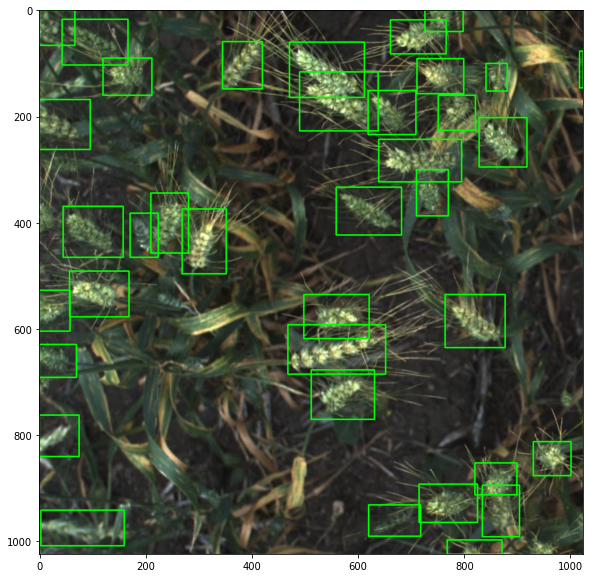

In [18]:
plot_img(train_data,21)

In [19]:
import math
import sys
import time
import torch

import torchvision.models.detection.mask_rcnn

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils

train_loss=[]
total_train_loss = []
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())
        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    return metric_logger

In [20]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, pretrained_backbone=True)

In [21]:
num_classes = 2  # 1 class (wheat) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [22]:
from engine import evaluate
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer,train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the valid dataset
    evaluate(model, valid_data_loader, device=device)

Epoch: [0]  [  0/169]  eta: 0:18:09  lr: 0.000035  loss: 4.9664 (4.9664)  loss_classifier: 0.7216 (0.7216)  loss_box_reg: 0.4559 (0.4559)  loss_objectness: 3.5627 (3.5627)  loss_rpn_box_reg: 0.2262 (0.2262)  time: 6.4455  data: 3.3900  max mem: 11464
Epoch: [0]  [ 10/169]  eta: 0:06:03  lr: 0.000332  loss: 3.1569 (3.0282)  loss_classifier: 0.6380 (0.6470)  loss_box_reg: 0.4814 (0.4785)  loss_objectness: 1.7346 (1.6757)  loss_rpn_box_reg: 0.2202 (0.2270)  time: 2.2891  data: 0.3556  max mem: 11729
Epoch: [0]  [ 20/169]  eta: 0:05:14  lr: 0.000629  loss: 1.7032 (2.3499)  loss_classifier: 0.5502 (0.5916)  loss_box_reg: 0.4649 (0.4686)  loss_objectness: 0.4522 (1.0741)  loss_rpn_box_reg: 0.2106 (0.2155)  time: 1.8955  data: 0.0589  max mem: 11729
Epoch: [0]  [ 30/169]  eta: 0:04:45  lr: 0.000927  loss: 1.3880 (2.0234)  loss_classifier: 0.4756 (0.5424)  loss_box_reg: 0.4667 (0.4747)  loss_objectness: 0.2589 (0.7994)  loss_rpn_box_reg: 0.1904 (0.2068)  time: 1.9192  data: 0.0652  max mem: 11

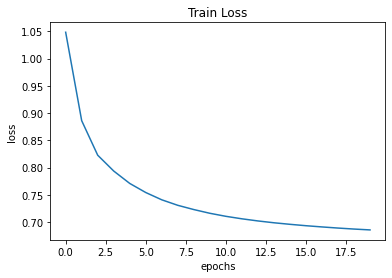

In [23]:
plt.title('Train Loss')
plt.plot(total_train_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [24]:
evaluate(model, test_data_loader, device=device)

creating index...
index created!
Test:  [ 0/42]  eta: 0:01:57  model_time: 0.4649 (0.4649)  evaluator_time: 0.5776 (0.5776)  time: 2.7924  data: 1.5164  max mem: 11729
Test:  [41/42]  eta: 0:00:01  model_time: 0.3659 (0.3713)  evaluator_time: 0.5474 (0.6127)  time: 1.0471  data: 0.0329  max mem: 11729
Test: Total time: 0:00:47 (1.1401 s / it)
Averaged stats: model_time: 0.3659 (0.3713)  evaluator_time: 0.5474 (0.6127)
Accumulating evaluation results...
DONE (t=0.22s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.888
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.365
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.100
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.467
 Average Recall     (AR) @[ Io

In [25]:
images, targets = next(iter(test_data_loader))
images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total bounding box of image:  42
Total bounding box of image:  28
Total bounding box of image:  33
Total bounding box of image:  13
Total bounding box of image:  40
Total bounding box of image:  48


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total bounding box of image:  22
Total bounding box of image:  20


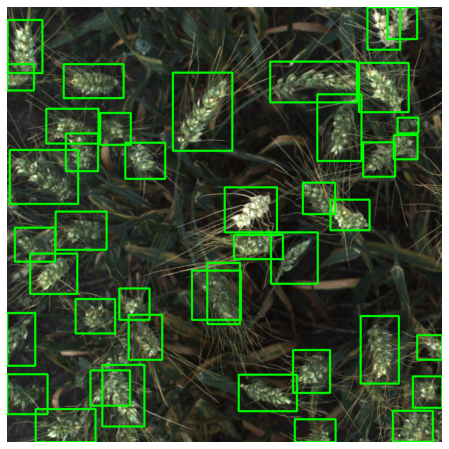

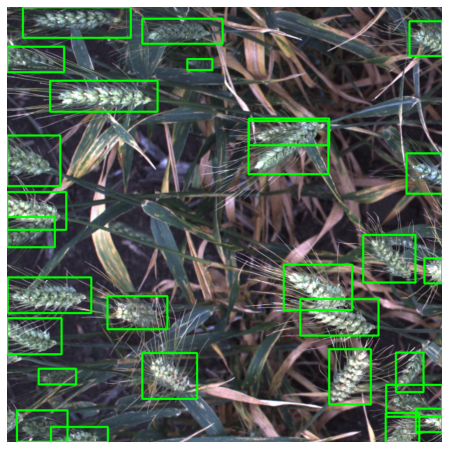

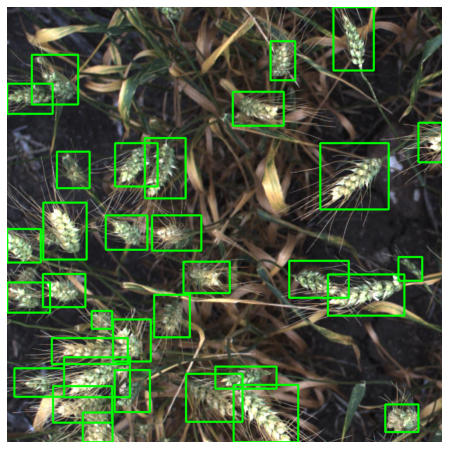

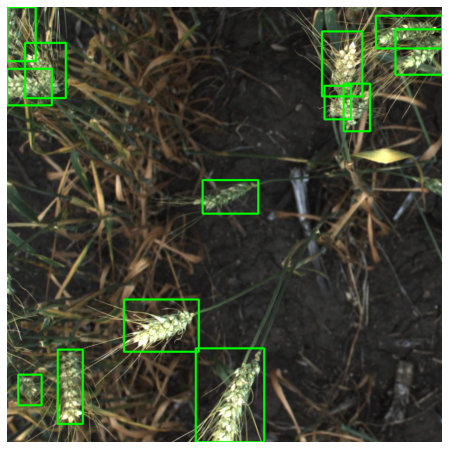

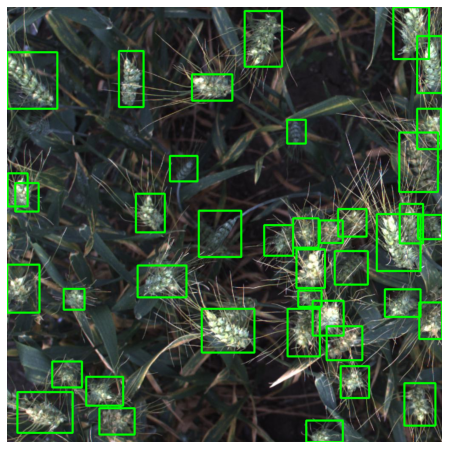

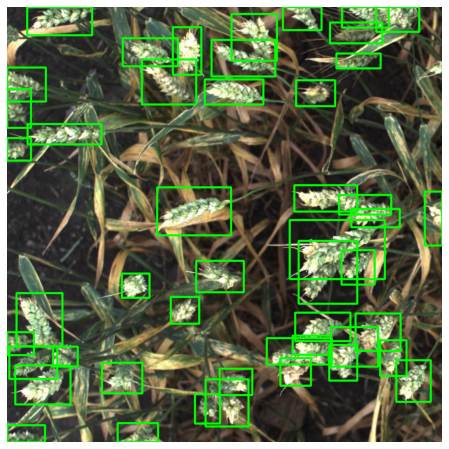

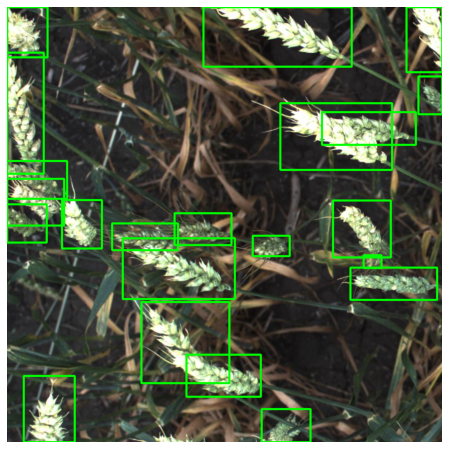

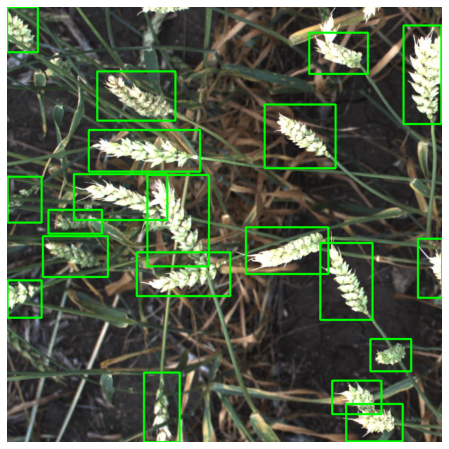

In [26]:
for i in range(0,8):
  boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
  sample = images[i].permute(1,2,0).cpu().numpy()
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))
  print ("Total bounding box of image: ",len(boxes))
  for box in boxes:
      cv2.rectangle(sample,
                    (box[0], box[1]),
                    (box[2], box[3]),
                    (0, 255, 0), 3)

  ax.set_axis_off()
  ax.imshow(sample)

In [26]:
model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total bounding box of image (predict):  39
Total bounding box of image (predict):  28
Total bounding box of image (predict):  35
Total bounding box of image (predict):  12
Total bounding box of image (predict):  36
Total bounding box of image (predict):  46


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total bounding box of image (predict):  20
Total bounding box of image (predict):  20


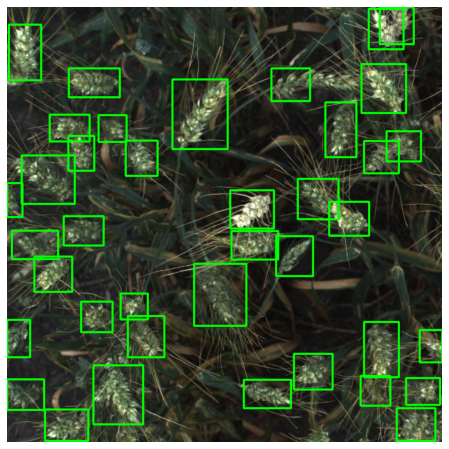

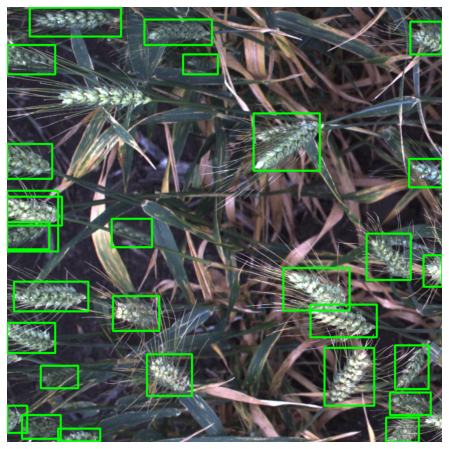

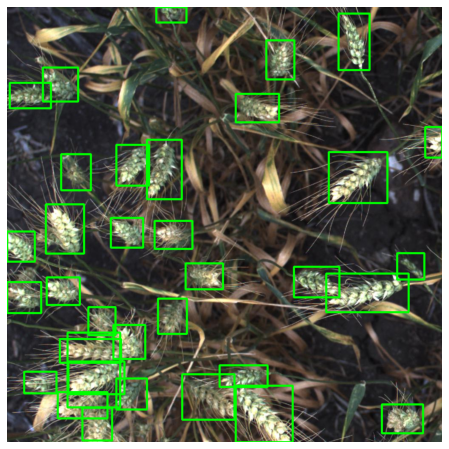

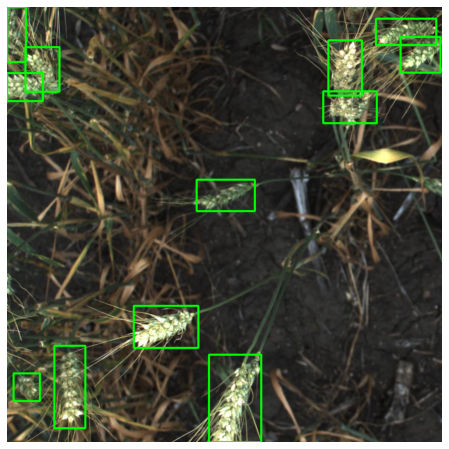

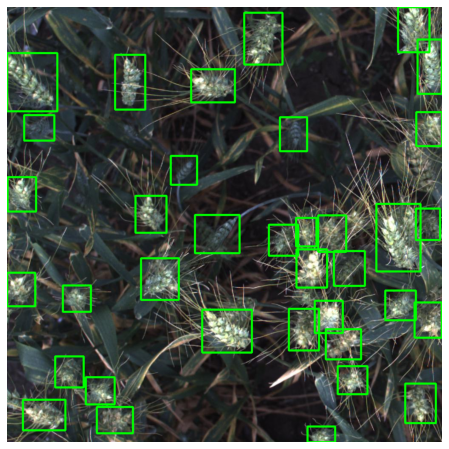

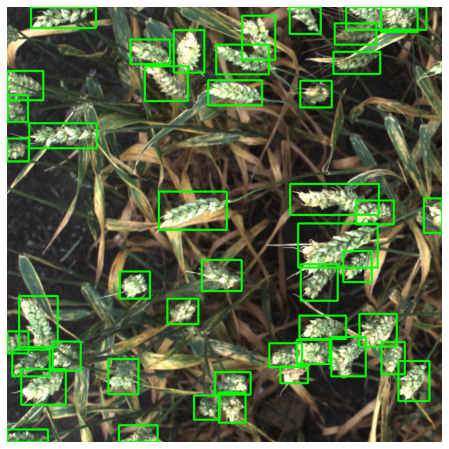

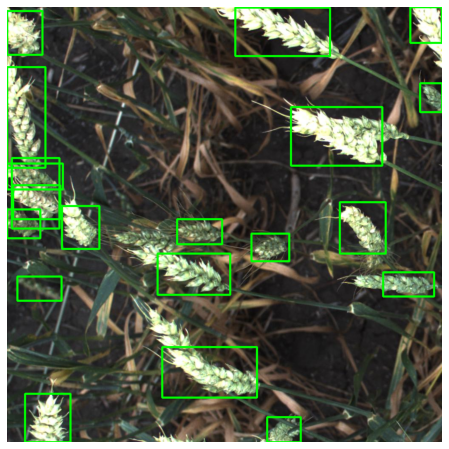

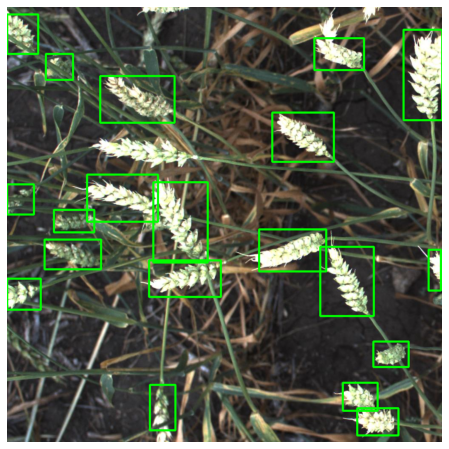

In [27]:
for i in range(0,8):
  detection_threshold = 0.7
  sample_ = images[i].permute(1,2,0).cpu().numpy()
  boxes_ = outputs[i]['boxes'].data.cpu().numpy()
  scores_ = outputs[i]['scores'].data.cpu().numpy()

  boxes_ = boxes_[scores_ >= detection_threshold].astype(np.int32)
  fig, ax = plt.subplots(1, 1, figsize=(16, 8))
  print ("Total bounding box of image (predict): ",len(boxes_))
  for box in boxes_:
      # print('bounding box: ',box[0],' ',box[1],' ',box[2],' ',box[3])
      cv2.rectangle(sample_,
                    (box[0], box[1]),
                    (box[2], box[3]),
                    (0, 255, 0), 3)

  ax.set_axis_off()
  ax.imshow(sample_)